<a href="https://colab.research.google.com/github/waynew99/592-final-project/blob/main/Flirting_Detection_LSTM_OPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Installations

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
print(np.__version__)

1.25.2


In [2]:
! pip install datasets
! pip install codecarbon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 15.7 MB/s eta 0:00:00


# Load Dataset

In [3]:
# Dataset 1 (from hugging face)
from datasets import load_dataset, Dataset, concatenate_datasets, ClassLabel, Features
from codecarbon import EmissionsTracker
dataset = load_dataset("ieuniversity/flirty_or_not")
dataset = dataset.remove_columns('id')

train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1584 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/212 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/318 [00:00<?, ? examples/s]

In [4]:
# Dataset 2 (from local upload)
data = pd.read_csv('flirting_rated.csv')
data.drop_duplicates(subset=['texts'], inplace=True)
data.dropna(subset=['label'], inplace=True)
dataset_2 = Dataset.from_pandas(data)
print(len(dataset_2))

2650


In [5]:
split_train_dataset = dataset_2.train_test_split(test_size=0.2)['train']
split_valid_dataset = dataset_2.train_test_split(test_size=0.2)['test'].train_test_split(test_size=0.5)['train']
split_test_dataset = dataset_2.train_test_split(test_size=0.2)['test'].train_test_split(test_size=0.5)['test']

print(len(split_train_dataset))
print(len(split_valid_dataset))
print(len(split_test_dataset))

class_label = ClassLabel(names=['neutral', 'flirty'])

# Define features for the dataset
features = Features({
    'label': class_label,
    'texts': split_train_dataset.features['texts']
})

split_train_dataset = Dataset.from_dict({
    'label': split_train_dataset['label'],
    'texts': split_train_dataset['texts']
}, features=features)

split_valid_dataset = Dataset.from_dict({
    'label': split_valid_dataset['label'],
    'texts': split_valid_dataset['texts']
}, features=features)

split_test_dataset = Dataset.from_dict({
    'label': split_test_dataset['label'],
    'texts': split_test_dataset['texts']
}, features=features)


print(split_train_dataset.features)
print(train_dataset.features)


2120
265
265
{'label': ClassLabel(names=['neutral', 'flirty'], id=None), 'texts': Value(dtype='string', id=None)}
{'label': ClassLabel(names=['neutral', 'flirty'], id=None), 'texts': Value(dtype='string', id=None)}


In [6]:
# The second dataset is NOT balanced: Majority is neutral (0)
total_flirty = 0
for label in split_train_dataset['label']:
  if label != 0:
    total_flirty += 1

for label in split_valid_dataset['label']:
  if label != 0:
    total_flirty += 1

for label in split_test_dataset['label']:
  if label != 0:
    total_flirty += 1
print(total_flirty/2659)

0.14968033095148553


In [7]:
train_dataset_final = concatenate_datasets([split_train_dataset, train_dataset])
validation_dataset_final = concatenate_datasets([validation_dataset, split_valid_dataset])
test_dataset_final = concatenate_datasets([test_dataset, split_test_dataset])

In [8]:
TRAIN_SIZE = len(train_dataset_final)
VALIDATION_SIZE = len(validation_dataset_final)
TEST_SIZE = len(test_dataset_final)
print(TRAIN_SIZE, VALIDATION_SIZE, TEST_SIZE)

3704 477 583


In [9]:
total_length = 0
total_samples = 5000

for sample in train_dataset_final['texts']:
    # print(sample)
    # Calculate the length of each data instance
    # Assuming each data instance is a dictionary-like object with a 'text' key
    words = sample.split()
    length = len(words)
    total_length += length

for sample in validation_dataset_final['texts']:
    # print(sample)
    # Calculate the length of each data instance
    # Assuming each data instance is a dictionary-like object with a 'text' key
    words = sample.split()
    length = len(words)
    total_length += length

for sample in test_dataset_final['texts']:
    # print(sample)
    # Calculate the length of each data instance
    # Assuming each data instance is a dictionary-like object with a 'text' key
    words = sample.split()
    length = len(words)
    total_length += length

# Compute the average length
average_length = total_length / total_samples

print("Average length of each data instance:", average_length)

Average length of each data instance: 8.3516


In [10]:
total_flirty = 0
for label in train_dataset_final['label']:
  total_flirty += label
print(total_flirty/TRAIN_SIZE)

total_flirty = 0
for label in validation_dataset_final['label']:
  total_flirty += label
print(total_flirty/VALIDATION_SIZE)

total_flirty = 0
for label in test_dataset_final['label']:
  total_flirty += label
print(total_flirty/VALIDATION_SIZE)

0.2994060475161987
0.31027253668763105
0.41509433962264153


# Preprocess Dataset: Converting Text Data into Vectors/Numbers
Models cannot directly process raw text, so we need to convert the text into numbers using TensorFlow's `TextVectorization` layer. Specifically, we can perform the following 3 operations all at once, by constructing this layer and feeding the data into it.

* Standardization: preprocessing the text, typically to change all text to lowercase and remove punctuation to simplify the dataset.
* Tokenization: dividing text into individual words called tokens.
* Vectorization: converting tokens into numbers so they can be fed into a neural network.

Constructing the layer is very easy (we simply call the function), but there are some hyperparameters we need to determine first.

## TextVectorization
First, *maximum vocabulary size* and *maximum sequence length* are 2 hyperparameters defined based on the nature of the dataset and the memory constraints of the machine.

### Maximum Vocabulary Size (`max_tokens`)

This parameter determines the number of unique words that are considered when vectorizing texts. To decide this:

*   Tokenize your dataset to find out the total number of unique tokens it contains.
*   Evaluate your hardware's memory constraints since a larger vocabulary will require more memory.

Typically, a number between 10,000 to 100,000 works well for many tasks, but if your dataset is very specialized, smaller might be enough. Also, it's often best to choose a number that is slightly above the number of unique tokens actually observed in your data to account for uncertainties. However, if the vocabulary size is significantly higher than the actual number of unique tokens, it can lead to increased memory overhead, slower training speed, and most importantly, possibility of overfitting.

In [11]:
# access the text and labels after the dataset is loaded successfully
texts = [row['texts'] for row in train_dataset_final]
labels = [row['label'] for row in train_dataset_final]

In [12]:
# Calculate the number of unique tokens using TensorFlow's tokenizer
from collections import Counter

# Flatten the list of sentences into a single list of words
all_words = [word for text in texts for word in text.split()]

# Count the unique words
word_count = Counter(all_words)
# ~4000 unique words/tokens in the training + validation set
print(f"Total unique tokens in the raw text: {len(word_count)}")

# Thus, probably use about 4000-5000 for token size
MAX_FEATURES = 5000  # Size of the vocabulary

Total unique tokens in the raw text: 5432


### Maxmimum Sequence Length (`output_sequence_length`)

This parameter controls the maximum number of tokens that will be considered in each example. To find a reasonable maximum sequence length:

- Calculate the length of each text example in your dataset.
- Plot a histogram of these lengths to get a sense of the distribution.
- Use this information to decide on a length that covers most of your texts without being excessively long.

The `output_sequence_length` parameter is used to pad or truncate sequences to this maximum length. If a text is shorter than this, it will be padded with zeros, and if it's longer, it will be truncated.

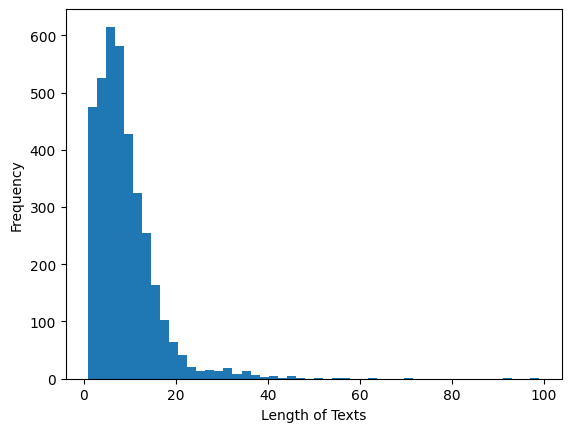

Min: 1.000
Q1: 4.000
Median: 7.000
Q3: 11.000
Max: 99.000
20


In [13]:
# Find a reasonable sequence length
import matplotlib.pyplot as plt

# Calculate the length for each piece of text
text_lengths = [len(text.split()) for text in texts]

# Plot a histogram
plt.hist(text_lengths, bins=50)
plt.xlabel('Length of Texts')
plt.ylabel('Frequency')
plt.show()

# 5 number summary showing distribution of lengths
# calculate quartiles
quartiles = np.percentile(text_lengths, [25, 50, 75])
# calculate min/max
len_min, len_max = min(text_lengths), max(text_lengths)
# print 5-number summary
print('Min: %.3f' % len_min)
print('Q1: %.3f' % quartiles[0])
print('Median: %.3f' % quartiles[1])
print('Q3: %.3f' % quartiles[2])
print('Max: %.3f' % len_max)

# Determine a suitable maximum length (e.g., the 95th percentile could be a good starting point)
SEQUENCE_LENGTH = int(np.percentile(text_lengths, 95)) # Length of the input sequences
print(SEQUENCE_LENGTH)

### Output Mode and Standardization

These are 2 more hyperparameters for the `TextVectorization` layer.

First, for output mode, we are setting it to `int`. As a result, the layer converts the tokens into integer indices. Each unique token is assigned a specific integer value, and texts are converted into sequences of these integers. In many deep learning models for text based on neural networks, `int` is the preferred option because it works very well with Embedding Layers, which are efficient and powerful mechanisms for handling sequences of tokens.

Next, for standardization, we are currently just changing each token into lowercase, a very common standardize function. We are *not* removing punctuation and special characters because there may be special characters (e.g. emojis) that actually contribute to the meaning of the text, so removing them may reduce context.

As a side note, we do not need to further define a custome split hyperparameter because splitting by whitespace (default) is sufficient for our case.

In [55]:
import re
import string
import keras

# @keras.saving.register_keras_serializable()
# def custom_standardization(text):
#   # Make text lowercase
#   text = tf.strings.lower(text)
#   # Only remove common punctuation
#   # common_punct = r'[,.?!]'
#   common_punct = r"[,.?!\'\"\<\>\{\}\[\]\^\&\\\%\$\#\@\|]"
#   text = tf.strings.regex_replace(text, common_punct, '')
#   return text

# Define the function that will treat punctuation as tokens?
@keras.saving.register_keras_serializable()
def custom_standardization(text):
  # Make text lowercase
  text = tf.strings.lower(text)
  # Remove insignificant punctuation from the text
  common_punct = r"[,\'\"\<\>\{\}\[\]\^\&\\\%\$\#\@\|]"
  text = tf.strings.regex_replace(text, common_punct, '')
  # Replace punctuations with space + punctuation + space
  for punct in string.punctuation:
      text = tf.strings.regex_replace(text, re.escape(punct), f" {punct} ")
  # Remove extra spaces
  text = tf.strings.strip(text)
  text = tf.strings.regex_replace(text, ' +', ' ')
  return text

In [56]:
# tokenization & vectorization
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_FEATURES,
    standardize=custom_standardization, # lowercase & remove common punctuation
    output_mode='int', # int is preferred mode in modern day DL tasks
    output_sequence_length=SEQUENCE_LENGTH)

In [57]:
# adapt the TextVectorization layer to text data so that it can build the vocabulary
vectorize_layer.adapt(texts)
# test
len(vectorize_layer.get_vocabulary())

4029

In [36]:
# # Let's prepare a dataset to illustrate the functionality
# example_dataset = tf.data.Dataset.from_tensor_slices(["Hello!", "Hello !", "It's a? test 😉?", "It's a test :) :("])
# vectorize_layer.adapt(example_dataset)

# print(vectorize_layer.get_vocabulary())

# # Example of how the layer will preprocess the data
# for example in example_dataset:
#     print("Original:", example.numpy())
#     vectorized_text = vectorize_layer(example)
#     print("Vectorized:", vectorized_text.numpy())

## Convert to Tensorflow Dataset (for training)

Now, we can convert the raw text data into a form that a TensorFlow machine learning model can understand (i.e., numeric tensors) using the TextVectorization layer, preparing it in batches to be fed into the model for training or inference.

We can either (1) do the convertion as part of data preprocessing, or (2) leave it to the LSTM model itself. Option (2) generalizes better if we want to deploy and test the model since it can automatically convert text into numbers without any manual preprocessing, so we are going with this option.

In [39]:
# another hyperparameter
BATCH_SIZE = 32
# takes text data (a list of strings) and creates Dataset object
# each element of the dataset is one piece of text from your original list
text_ds = tf.data.Dataset.from_tensor_slices(texts).batch(BATCH_SIZE)
# Turn the texts into sequences of integers [Option 1]
# text_int_sequences = text_ds.map(vectorize_layer)
# convert corresponding labels to tensorflow format
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.int32)).batch(BATCH_SIZE)

In [40]:
# integer representing the number of elements to shuffle at a time
shuffle_buffer_size = TRAIN_SIZE # the number of data in the training set
# build the training dataset & optimize it for training
# train_ds = tf.data.Dataset.zip((text_int_sequences, label_ds)) \ # [Option 1]
train_ds = tf.data.Dataset.zip((text_ds, label_ds)) \
            .shuffle(buffer_size=shuffle_buffer_size) \
            .cache() \
            .prefetch(buffer_size=tf.data.AUTOTUNE)

### Convert Validation Set and Test Set as well

In [41]:
val_texts = [row['texts'] for row in validation_dataset_final]
val_labels = [row['label'] for row in validation_dataset_final]
val_text_ds = tf.data.Dataset.from_tensor_slices(val_texts).batch(BATCH_SIZE)
val_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(val_labels, tf.int32)).batch(BATCH_SIZE)
# val_text_int_sequences = val_text_ds.map(vectorize_layer) # [Option 1]
# note: no shuffling for validation and test sets
val_ds = tf.data.Dataset.zip((val_text_ds, val_label_ds)) \
            .cache() \
            .prefetch(buffer_size=tf.data.AUTOTUNE)

In [42]:
test_texts = [row['texts'] for row in test_dataset_final]
test_labels = [row['label'] for row in test_dataset_final]
test_text_ds = tf.data.Dataset.from_tensor_slices(test_texts).batch(BATCH_SIZE)
test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.int32)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.zip((test_text_ds, test_label_ds)) \
            .cache() \
            .prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
# sanity check
# for example, label in val_ds.take(1):
#   print('texts: ', example.numpy())
#   print()
#   print('labels: ', label.numpy())
# exact_sample_count = sum(1 for _ in train_ds.unbatch())  # This can be slow for large datasets
# print("Total number of samples in train_ds:", exact_sample_count)

# Build LSTM Model

In [68]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# More Hyperparameters
EMBEDDING_DIM = 128    # Dimension of the embedding vectors
LSTM_UNITS = 16        # The number of units in the LSTM layer (x2 if bidirectional is specified)
DROPOUT_RATE = 0.25
REGULAR_RATE = 0.001

model = tf.keras.Sequential([
    # [Option 2] convert text to vectors
    vectorize_layer,
    # TODO: can switch the embedding to be a pre-trained model, e.g. word2vec
    layers.Embedding(
        input_dim=MAX_FEATURES + 1,
        # input_dim=len(vectorize_layer.get_vocabulary()) + 1,
        output_dim=EMBEDDING_DIM,
        input_length=SEQUENCE_LENGTH,
        mask_zero=True),
    # Avoid overfitting
    layers.SpatialDropout1D(DROPOUT_RATE),
    # LSTM layer
    layers.Bidirectional(layers.LSTM(
        LSTM_UNITS,
        dropout=DROPOUT_RATE,
        recurrent_dropout=DROPOUT_RATE,
        return_sequences=True)),
    layers.Bidirectional(layers.LSTM(
        LSTM_UNITS,
        dropout=DROPOUT_RATE,
        recurrent_dropout=DROPOUT_RATE)),
    # layers.LSTM(
    #     LSTM_UNITS,
    #     dropout=DROPOUT_RATE,
    #     recurrent_dropout=DROPOUT_RATE,
    #     kernel_regularizer=regularizers.l2(REGULAR_RATE),
    #     recurrent_regularizer=regularizers.l2(REGULAR_RATE)),
    # increasing complexity
    # layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(REGULAR_RATE)),
    # using sigmoid activation function for binary classification problem
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
print(MAX_FEATURES)
print(BATCH_SIZE)

5000
32


In [69]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (Text  (None, 20)                0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 20, 128)           640128    
                                                                 
 spatial_dropout1d_4 (Spati  (None, 20, 128)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_8 (Bidirecti  (None, 20, 32)            18560     
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 32)                6272      
 onal)                                                

# Training

In [70]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    restore_best_weights=True  # Restores model weights from the epoch with the minimum validation loss.
)

# Save model checkpoints
checkpoint_filepath = 'training/best_model.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=3,
    verbose=1
)

In [71]:
# Even More Hyperparameters
EPOCHS = 10

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[early_stopping, reduce_lr])

Epoch 1/10
116/116 [==============================] - 37s 147ms/step - loss: 0.5934 - accuracy: 0.7238 - val_loss: 0.4264 - val_accuracy: 0.8595 - lr: 0.0010
Epoch 2/10
116/116 [==============================] - 16s 134ms/step - loss: 0.3458 - accuracy: 0.8699 - val_loss: 0.3197 - val_accuracy: 0.8742 - lr: 0.0010
Epoch 3/10
116/116 [==============================] - 15s 133ms/step - loss: 0.1968 - accuracy: 0.9352 - val_loss: 0.2683 - val_accuracy: 0.9036 - lr: 0.0010
Epoch 4/10
116/116 [==============================] - 16s 140ms/step - loss: 0.1241 - accuracy: 0.9565 - val_loss: 0.2634 - val_accuracy: 0.9182 - lr: 0.0010
Epoch 5/10
116/116 [==============================] - 17s 143ms/step - loss: 0.0926 - accuracy: 0.9692 - val_loss: 0.2706 - val_accuracy: 0.9224 - lr: 0.0010
Epoch 6/10
116/116 [==============================] - 16s 135ms/step - loss: 0.0787 - accuracy: 0.9749 - val_loss: 0.2578 - val_accuracy: 0.9245 - lr: 0.0010
Epoch 7/10
116/116 [==============================] 

In [73]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

19/19 [==============================] - 0s 16ms/step - loss: 0.2138 - accuracy: 0.9383
Test Loss: 0.21379561722278595
Test Accuracy: 0.9382504224777222


In [74]:
sample_text = ('Lets explore each others body')
tracker = EmissionsTracker()
tracker.start()
predictions = model.predict(np.array([sample_text]))
emissions: float = tracker.stop()
print(f"Emissions: {emissions} kg")
predictions

[codecarbon INFO @ 23:14:30] [setup] RAM Tracking...
[codecarbon INFO @ 23:14:30] [setup] GPU Tracking...
[codecarbon INFO @ 23:14:30] No GPU found.
[codecarbon INFO @ 23:14:30] [setup] CPU Tracking...
[codecarbon WARNING @ 23:14:30] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 23:14:31] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 23:14:31] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 23:14:31] >>> Tracker's metadata:
[codecarbon INFO @ 23:14:31]   Platform system: Linux-6.1.58+-x86_64-with-glibc2.35
[codecarbon INFO @ 23:14:31]   Python version: 3.10.12
[codecarbon INFO @ 23:14:31]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 23:14:31]   Available RAM : 12.675 GB
[codecarbon INFO @ 23:14:31]   CPU count: 2
[codecarbon INFO @ 23:14:31]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 23:14:31]   GPU count: None
[codec

1/1 [==============================] - 1s 1s/step


[codecarbon INFO @ 23:14:33] Energy consumed for RAM : 0.000002 kWh. RAM Power : 4.753043174743652 W
[codecarbon INFO @ 23:14:33] Energy consumed for all CPUs : 0.000016 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:33] 0.000018 kWh of electricity used since the beginning.


Emissions: 8.044864883624477e-06 kg


array([[0.9963056]], dtype=float32)

# Analysis

## Training Plots

In [75]:
import matplotlib.pyplot as plt

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [76]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

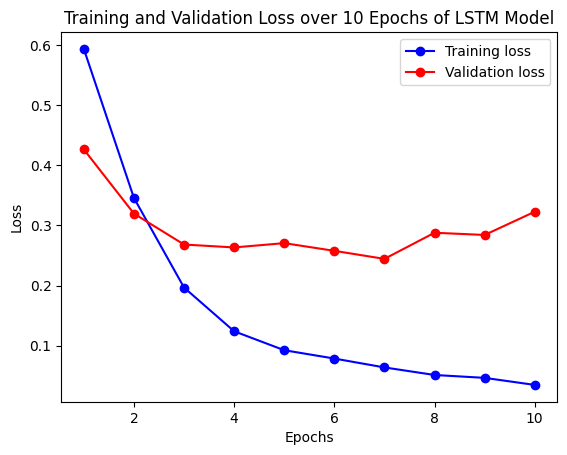

In [77]:
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo-', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title(f'Training and Validation Loss over {EPOCHS} Epochs of LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

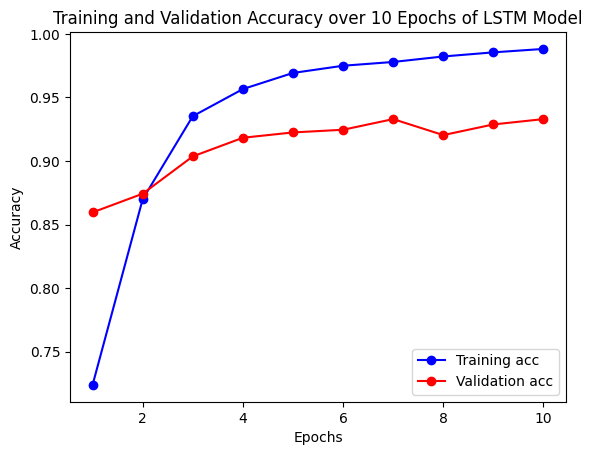

In [78]:
plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
plt.title(f'Training and Validation Accuracy over {EPOCHS} Epochs of LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Confusion Matrix

In [79]:
from sklearn.metrics import confusion_matrix

# make predictions on test set
y_pred = model.predict(test_ds)
# convert these probabilities to binary predictions
# e.g., classify samples with a probability > 0.5 as positive (flirty)
y_pred_binary = (y_pred > 0.5).astype("int32")
# Prepare the true labels. You'll need to concatenate them into one array.
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_binary)

19/19 [==============================] - 2s 16ms/step


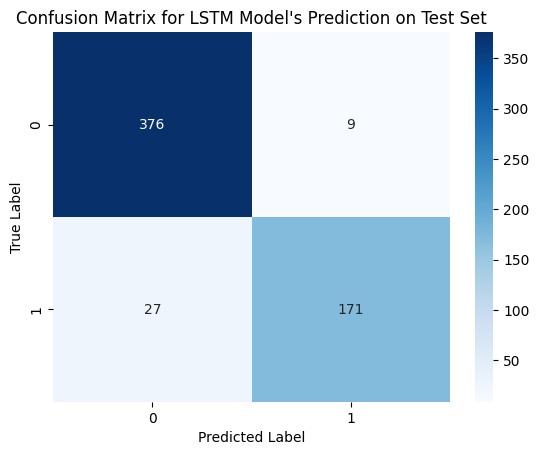

In [80]:
import seaborn as sns

# plot the confusion matrix using seaborn (for better visualization)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title("Confusion Matrix for LSTM Model's Prediction on Test Set")
plt.show()

## See Wrong Predictions

In [81]:
# Get binary prediction produced by model
y_pred1 = (y_pred > 0.5).astype("int32").flatten()
# Collect true labels
y_true1 = np.concatenate([labels.numpy() for inputs, labels in test_ds]).flatten()
# Collect input data (assuming the input data is a NumPy array or a list)
x_test1 = np.concatenate([inputs.numpy() for inputs, labels in test_ds]).flatten()

In [82]:
# Identify indices of incorrect predictions
false_positives = np.where((y_pred1 == 1) & (y_true1 == 0))[0]
false_negatives = np.where((y_pred1 == 0) & (y_true1 == 1))[0]
# Retrieve the corresponding input text for false positives and false negatives
fp_texts = [x_test1[i] for i in false_positives]
fn_texts = [x_test1[i] for i in false_negatives]

In [83]:
# Now, if you want to visualize some of them:
print("False Positives:")
for i, fp_idx in enumerate(false_positives):  # Show first 10 false positives
  print(f"Text: {fp_texts[i]} - Predicted: {y_pred[fp_idx]}, Actual: {y_true[fp_idx]}")
print("\n")
print("False Negatives:")
for i, fn_idx in enumerate(false_negatives):  # Show first 10 false negatives
  print(f"Text: {fn_texts[i]} - Predicted: {y_pred[fn_idx]}, Actual: {y_true[fn_idx]}")

False Positives:
Text: b'?*' - Predicted: [0.51064444], Actual: 0
Text: b'probably, i have no idea what i want/am looking for' - Predicted: [0.5539961], Actual: 0
Text: b'right' - Predicted: [0.62303746], Actual: 0
Text: b'just then' - Predicted: [0.6731782], Actual: 0
Text: b'croquet' - Predicted: [0.5653621], Actual: 0
Text: b'I know what u mean' - Predicted: [0.94362754], Actual: 0
Text: b'We bought a table that is a nice heavy wood table but it extends into a pong table \xf0\x9f\x98\x82 we rarely use it tho sadly' - Predicted: [0.7302538], Actual: 0
Text: b'2x better' - Predicted: [0.64636403], Actual: 0
Text: b"that's ironic because i didn't take the dog out of the backyard..." - Predicted: [0.85634935], Actual: 0


False Negatives:
Text: b'oh yeah...' - Predicted: [0.17766057], Actual: 1
Text: b' are you available to hang out later' - Predicted: [0.0048202], Actual: 1
Text: b'Okay' - Predicted: [0.03821768], Actual: 1
Text: b'Me: Yeah I\xe2\x80\x99m not actually going to San Dieg

# Save the Model

In [84]:
import keras
print(keras.__version__)

import tensorflow
print(tensorflow.__version__)

2.15.0
2.15.0


In [85]:
model.save('LSTM-Flirt.keras')

In [86]:
from tensorflow import keras

new_model = keras.models.load_model('LSTM-Flirt.keras')

# Show the model architecture
new_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (Text  (None, 20)                0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 20, 128)           640128    
                                                                 
 spatial_dropout1d_4 (Spati  (None, 20, 128)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_8 (Bidirecti  (None, 20, 32)            18560     
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 32)                6272      
 onal)                                                

In [87]:
new_model.evaluate(test_ds)

19/19 [==============================] - 3s 21ms/step - loss: 0.2138 - accuracy: 0.9383


[0.21379561722278595, 0.9382504224777222]